In [1]:
# %% [Cell 1]: Imports and Global Settings
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from typing import Tuple, Dict, List, Union, Optional
import time
from pathlib import Path
import matplotlib.pyplot as plt

# Set default device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Ensure reproducibility
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed(42)
np.random.seed(42)

In [2]:
# %% [Cell 2]: Data Preparation and Loading

def prepare_cifar10(
    batch_size: int = 128, 
    validation_split: float = 0.1,
    random_seed: int = 42,
    transform_train: Optional[transforms.Compose] = None,
    transform_val: Optional[transforms.Compose] = None
) -> Tuple[DataLoader, DataLoader, DataLoader, Dict]:
    """
    Prepares CIFAR10 dataset with train/val/test splits and given transforms.
    """
    
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    
    # Default transforms if none provided
    if transform_train is None:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                 (0.2023, 0.1994, 0.2010))
        ])
    if transform_val is None:
        transform_val = transform_train
    
    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_val
    )
    
    # Split train into train/val
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(validation_split * num_train))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=2, pin_memory=True
    )
    val_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=val_sampler,
        num_workers=2, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )
    
    dataset_info = {
        'num_classes': 10,
        'num_channels': 3,
        'image_size': 32,
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'test_size': len(test_dataset),
    }
    return train_loader, val_loader, test_loader, dataset_info

In [3]:
# %% [Cell 3]: Model Definitions (VGG11 and ResNet18)

class VGG11(nn.Module):
    """
    VGG11 variant for CIFAR10 with batch norm.
    """
    def __init__(self, num_classes: int = 10, init_weights: bool = True):
        super(VGG11, self).__init__()
        self.features = self._make_layers([
            64, 'M', 
            128, 'M', 
            256, 256, 'M', 
            512, 512, 'M', 
            512, 512, 'M'
        ])
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
        
        if init_weights:
            self._initialize_weights()

    def _make_layers(self, cfg: List[Union[int, str]]) -> nn.Sequential:
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


class BasicBlock(nn.Module):
    expansion: int = 1
    def __init__(self, in_planes: int, planes: int, stride: int = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, 
                          bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)


class ResNet18(nn.Module):
    """ResNet18 for CIFAR-10."""
    def __init__(self, num_classes: int = 10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        self._initialize_weights()

    def _make_layer(self, planes: int, num_blocks: int, stride: int):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_planes, planes, s))
            self.in_planes = planes * BasicBlock.expansion
        return nn.Sequential(*layers)

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', 
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [4]:
# %% [Cell 4]: Training Utilities (train, validate, plot)

class AverageMeter:
    """Tracks and stores averages and current values."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = self.sum = self.count = 0
        self.avg = 0

    def update(self, val: float, n: int = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device
) -> Tuple[float, float]:
    model.train()
    losses = AverageMeter()
    accuracy = AverageMeter()
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct = predicted.eq(targets).sum().item()
        
        losses.update(loss.item(), inputs.size(0))
        accuracy.update(correct / inputs.size(0), inputs.size(0))
    return losses.avg, accuracy.avg

def validate(
    model: nn.Module,
    val_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    model.eval()
    losses = AverageMeter()
    accuracy = AverageMeter()
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            _, predicted = outputs.max(1)
            correct = predicted.eq(targets).sum().item()
            
            losses.update(loss.item(), inputs.size(0))
            accuracy.update(correct / inputs.size(0), inputs.size(0))
    return losses.avg, accuracy.avg

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: str,
    patience: int,
    weight_decay: float,
    model_name: str = "model"
) -> Dict[str, List[float]]:
    device = torch.device(device)
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                          momentum=0.9, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', patience=4)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epoch_times': []
    }

    save_dir = Path('model_checkpoints')
    save_dir.mkdir(exist_ok=True)

    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_model_path = save_dir / f'best_{model_name}.pth'
    
    print(f"\n--- Training {model_name} ---")
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        epoch_time = time.time() - start_time
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_times'].append(epoch_time)
        
        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_without_improvement += 1
        
        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc*100:.2f}% "
              f"Val Loss: {val_loss:.4f} Val Acc: {val_acc*100:.2f}% "
              f"Time: {epoch_time:.2f}s LR: {current_lr:.6f}")

    # Save final model
    final_model_path = save_dir / f'final_{model_name}.pth'
    torch.save(model.state_dict(), final_model_path)

    return history

def plot_training_history(history: Dict[str, List[float]], title: str):
    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# %% [Cell 5]: Train & Evaluate VGG11

# Data augmentation & normalization for training
transform_train_vgg = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

transform_val_vgg = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

vgg_train_loader, vgg_val_loader, vgg_test_loader, vgg_dataset_info = prepare_cifar10(
    batch_size=128,
    validation_split=0.1,
    random_seed=42,
    transform_train=transform_train_vgg,
    transform_val=transform_val_vgg
)

vgg_model = VGG11(num_classes=10)
vgg_history = train_model(
    model=vgg_model,
    train_loader=vgg_train_loader,
    val_loader=vgg_val_loader,
    num_epochs=100,
    learning_rate=0.01,
    device=device,
    patience=15,
    weight_decay=1e-4,
    model_name="vgg11"
)

Files already downloaded and verified
Files already downloaded and verified

--- Training vgg11 ---
Epoch [1/100] Train Loss: 1.6146 Train Acc: 39.05% Val Loss: 1.3497 Val Acc: 51.08% Time: 13.79s LR: 0.010000
Epoch [2/100] Train Loss: 1.1522 Train Acc: 58.49% Val Loss: 1.0228 Val Acc: 63.50% Time: 13.47s LR: 0.010000
Epoch [3/100] Train Loss: 0.9626 Train Acc: 65.85% Val Loss: 0.9739 Val Acc: 65.92% Time: 13.29s LR: 0.010000
Epoch [4/100] Train Loss: 0.8386 Train Acc: 70.66% Val Loss: 0.8976 Val Acc: 68.84% Time: 13.19s LR: 0.010000
Epoch [5/100] Train Loss: 0.7568 Train Acc: 73.58% Val Loss: 0.7985 Val Acc: 72.14% Time: 13.61s LR: 0.010000
Epoch [6/100] Train Loss: 0.6919 Train Acc: 76.01% Val Loss: 0.7233 Val Acc: 75.14% Time: 13.52s LR: 0.010000
Epoch [7/100] Train Loss: 0.6380 Train Acc: 77.88% Val Loss: 0.6354 Val Acc: 77.56% Time: 13.28s LR: 0.010000
Epoch [8/100] Train Loss: 0.5994 Train Acc: 79.28% Val Loss: 0.6430 Val Acc: 77.58% Time: 13.29s LR: 0.010000
Epoch [9/100] Train 

In [6]:
# %% [Cell 6]: Train & Evaluate ResNet18

transform_train_resnet = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

transform_val_resnet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

resnet_train_loader, resnet_val_loader, resnet_test_loader, resnet_dataset_info = prepare_cifar10(
    batch_size=128,
    validation_split=0.1,
    random_seed=42,
    transform_train=transform_train_resnet,
    transform_val=transform_val_resnet
)

resnet_model = ResNet18(num_classes=10)
resnet_history = train_model(
    model=resnet_model,
    train_loader=resnet_train_loader,
    val_loader=resnet_val_loader,
    num_epochs=100,
    learning_rate=0.01,
    device=device,
    patience=15,
    weight_decay=1e-4,
    model_name="resnet18"
)

Files already downloaded and verified
Files already downloaded and verified

--- Training resnet18 ---
Epoch [1/100] Train Loss: 1.6592 Train Acc: 37.69% Val Loss: 1.4893 Val Acc: 46.74% Time: 20.06s LR: 0.010000
Epoch [2/100] Train Loss: 1.1920 Train Acc: 57.47% Val Loss: 1.1570 Val Acc: 58.54% Time: 19.23s LR: 0.010000
Epoch [3/100] Train Loss: 0.9392 Train Acc: 66.65% Val Loss: 0.9066 Val Acc: 68.28% Time: 18.71s LR: 0.010000
Epoch [4/100] Train Loss: 0.7798 Train Acc: 72.44% Val Loss: 0.9271 Val Acc: 67.74% Time: 18.79s LR: 0.010000
Epoch [5/100] Train Loss: 0.6746 Train Acc: 76.32% Val Loss: 0.6813 Val Acc: 76.24% Time: 19.13s LR: 0.010000
Epoch [6/100] Train Loss: 0.5966 Train Acc: 79.16% Val Loss: 0.6454 Val Acc: 77.46% Time: 19.36s LR: 0.010000
Epoch [7/100] Train Loss: 0.5415 Train Acc: 81.06% Val Loss: 0.5888 Val Acc: 79.88% Time: 19.45s LR: 0.010000
Epoch [8/100] Train Loss: 0.4971 Train Acc: 82.59% Val Loss: 0.6346 Val Acc: 79.00% Time: 19.60s LR: 0.010000
Epoch [9/100] Tra

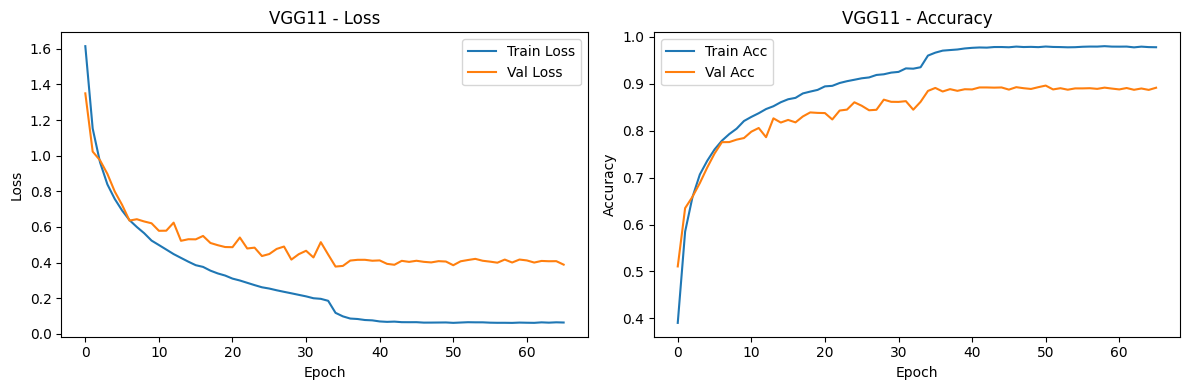

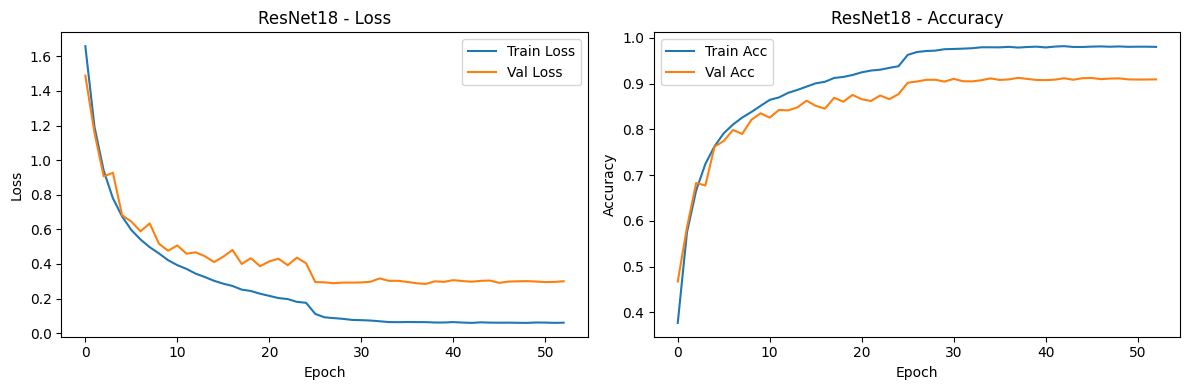

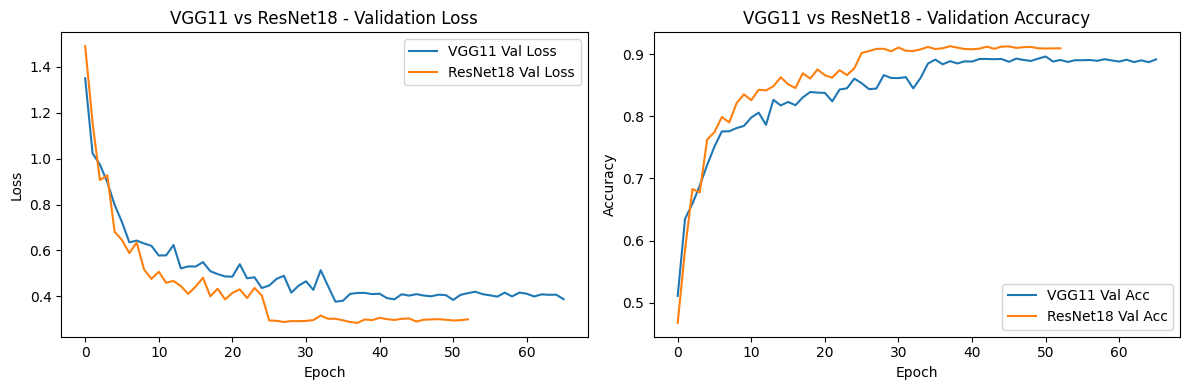

Comparison complete. Check the plots above.


In [7]:
# %% [Cell 7]: Compare Performance Side-by-Side

# Plot VGG11 training curves
plot_training_history(vgg_history, title="VGG11")

# Plot ResNet18 training curves
plot_training_history(resnet_history, title="ResNet18")

# Side-by-side comparison
# We'll create a combined plot for val accuracy and val loss for direct comparison

plt.figure(figsize=(12,4))

# Validation Loss
plt.subplot(1,2,1)
plt.plot(vgg_history['val_loss'], label='VGG11 Val Loss')
plt.plot(resnet_history['val_loss'], label='ResNet18 Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG11 vs ResNet18 - Validation Loss')
plt.legend()

# Validation Accuracy
plt.subplot(1,2,2)
plt.plot(vgg_history['val_acc'], label='VGG11 Val Acc')
plt.plot(resnet_history['val_acc'], label='ResNet18 Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG11 vs ResNet18 - Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("Comparison complete. Check the plots above.")

In [8]:
# %% [Cell 8]: Evaluate Models on Test Dataset

def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    """
    Evaluate the model on the test dataset.
    
    Args:
        model: Trained model.
        test_loader: DataLoader for test data.
        criterion: Loss function.
        device: Computation device.
    
    Returns:
        Tuple containing average loss and accuracy.
    """
    model.eval()
    losses = AverageMeter()
    accuracy = AverageMeter()
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            _, predicted = outputs.max(1)
            correct = predicted.eq(targets).sum().item()
            
            losses.update(loss.item(), inputs.size(0))
            accuracy.update(correct / inputs.size(0), inputs.size(0))
    
    return losses.avg, accuracy.avg

def load_model_checkpoint(model: nn.Module, checkpoint_path: Path):
    """
    Load model weights from a checkpoint.
    
    Args:
        model: Model architecture.
        checkpoint_path: Path to the checkpoint file.
    """
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    model.eval()

# Paths to the best model checkpoints
vgg_checkpoint = Path('model_checkpoints/best_vgg11.pth')
resnet_checkpoint = Path('model_checkpoints/best_resnet18.pth')

# Initialize models
vgg_model_test = VGG11(num_classes=10)
resnet_model_test = ResNet18(num_classes=10)

# Load best checkpoints
load_model_checkpoint(vgg_model_test, vgg_checkpoint)
load_model_checkpoint(resnet_model_test, resnet_checkpoint)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Evaluate VGG11
vgg_test_loss, vgg_test_acc = evaluate_model(
    model=vgg_model_test,
    test_loader=vgg_test_loader,
    criterion=criterion,
    device=device
)

# Evaluate ResNet18
resnet_test_loss, resnet_test_acc = evaluate_model(
    model=resnet_model_test,
    test_loader=resnet_test_loader,
    criterion=criterion,
    device=device
)

# Display Results
print("\n--- Test Set Evaluation ---")
print(f"VGG11 Test Loss: {vgg_test_loss:.4f} | Test Accuracy: {vgg_test_acc*100:.2f}%")
print(f"ResNet18 Test Loss: {resnet_test_loss:.4f} | Test Accuracy: {resnet_test_acc*100:.2f}%")


C:\Users\denis\AppData\Local\Temp\ipykernel_16740\3161697695.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))



--- Test Set Evaluation ---
VGG11 Test Loss: 0.4342 | Test Accuracy: 88.96%
ResNet18 Test Loss: 0.3360 | Test Accuracy: 90.24%


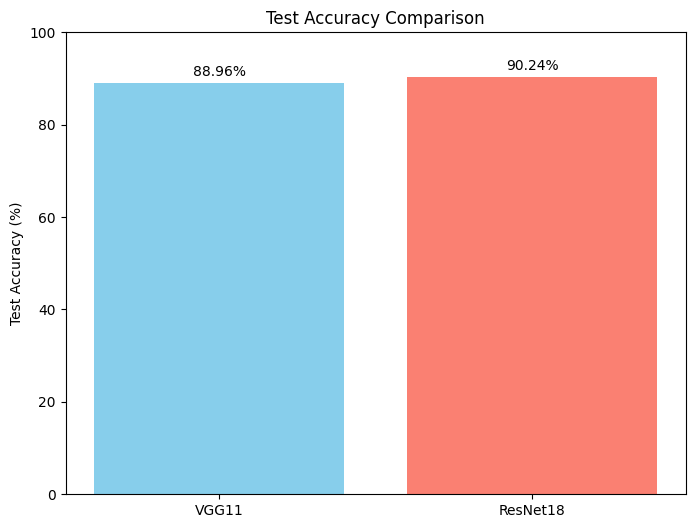

In [9]:
# %% [Cell 9]: Visualize Test Performance

# Create a bar chart for test accuracies
models = ['VGG11', 'ResNet18']
test_accuracies = [vgg_test_acc * 100, resnet_test_acc * 100]

plt.figure(figsize=(8,6))
bars = plt.bar(models, test_accuracies, color=['skyblue', 'salmon'])
plt.ylim(0, 100)
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')

# Annotate bars with accuracy values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0,3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()